# Transfer Learning 전이학습


* 기존의 이미 만들어진 모델을 사용하여 새로운 모델을 만든다. 
* **Transfer learning의 필요성**
    * Convolution network을 처음부터 학습시키는 것은 시간과 자원이 많이 든다.
    * 복잡한 모델일수록 학습시키기 어렵다. 
    * 실질적으로 처음부터 학습시키려면 많은 시도가 필요
* **Transfer learning 장점**
    * 적은 데이터로도 학습이 가능
    * 학습 속도도 빠르다. 
    * 예측을 더 높이는 방법이다.
    * 이미 잘 훈련된 모델이 있고, 특히 해당 모델과 유사한 문제를 해결하고자 할 때  transfer learning을 사용할 수 있다.
    * 예를 들어 Imagenet으로 훈련된 모형을 피부암 진단에 사용할 수 있다.

* 일반적으로 VGG, ResNet, gooGleNet 등 이미 이러한 사전에 학습이 완료된 모델(Pre-Training Model)을 가지고 우리가 원하는 학습에 미세 조정하여 학습시키는 방법이 Transfer Learning이다.

* **ConvNet as fixed feature extractor**: ConvNet 끝에 달린 fully-connected layer를 없애고, convolutional layer를 통해 처리되는 값만 얻는 방법이다. 전체 ConvNet을 target 데이터 세트의 고정된 feature 추출기로 사용할 수 있다는 것이다. top layer인 fully-connected layer만을 훈련한다.


**tf.keras.application 모듈**에서 이미 훈련된(pre-trained) model을 다운로드 할 수 있다.

훈련 시간을 단축하기 위하여 GPU를 활성화 하시오.

In [1]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  2.3.0


### 이미지 데이터를 loading한다.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 160
IMG_WIDTH = 160

### 디렉토리의 이미지를 dataset으로 생성한다.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_datagen = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [9]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### pre trained model을 다운로드 한다.

$HOME/.keras/models/ 폴더에 다운로드 된다.

In [10]:
image_size = 160
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


### Pre-trained model의 가중치 freeze

In [11]:
base_model.trainable = False

In [12]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### 마지막에 이미지 분류를 위한 Dense layer를 추가한다.

In [13]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### 모형을 훈련한다.

epoch수는 훈련시간을 고려하여 적절하게 선택한다.

In [25]:
epochs = 3
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/3
62/62 [==============================] - 31s 508ms/step - loss: 0.2170 - accuracy: 0.9456 - val_loss: 0.2066 - val_accuracy: 0.9365
Epoch 2/3
62/62 [==============================] - 31s 503ms/step - loss: 0.1726 - accuracy: 0.9538 - val_loss: 0.1743 - val_accuracy: 0.9435
Epoch 3/3
62/62 [==============================] - 32s 513ms/step - loss: 0.1455 - accuracy: 0.9588 - val_loss: 0.1527 - val_accuracy: 0.9476


### 훈련결과 시각화

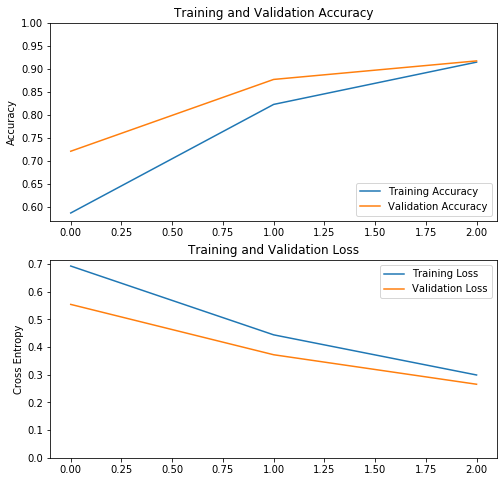

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### 이미지 분류 예측

In [21]:
probabilities = model.predict(validation_generator,1)

print(validation_generator.class_indices)
print(probabilities[:5])

{'cats': 0, 'dogs': 1}
[[0.38712123]
 [0.6758409 ]
 [0.9333664 ]
 [0.0571858 ]
 [0.4068076 ]]


### 훈련된 모형으로 예측하기

In [22]:
imgs, labels = validation_generator.next()

preds = (model.predict(imgs) > 0.5).astype("int32") 

In [23]:
classes = ['cat','dog']

labels

array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

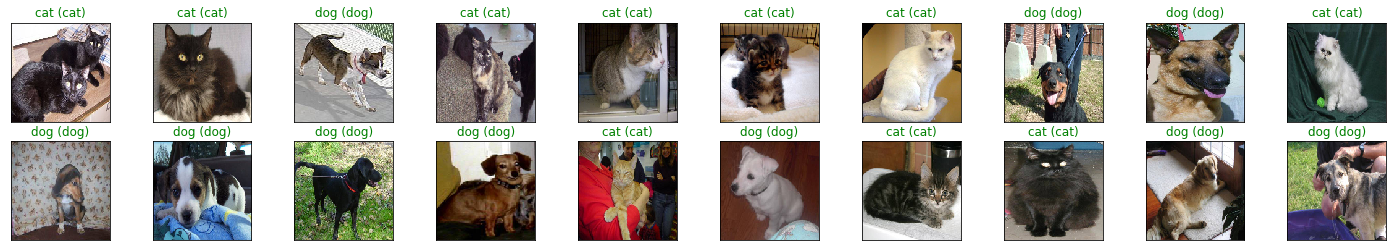

In [24]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(imgs[idx])
    ax.set_title("{} ({})".format(classes[preds[idx].item()], classes[int(labels[idx])]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# 실습
![image.png](./images/Pre-Trained-Model-Comparison.png)
1. tf.keras.applications (https://www.tensorflow.org/api_docs/python/tf/keras/applications) 을 확인해 보면 여러 가지 pre-trained model을 다운로드 할 수 있다. mobilenet외의 다른 모형을 사용하여 전이학습을 진행해 보고 비교 하시오.
